In [100]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import GridSearchCV

In [101]:
frb_data = pd.read_csv('frb-data.csv')
frb_data['Repeater'] = frb_data['Repeater'].map({'Yes': 1, 'No': 0})
frb_data['Repeater'] = frb_data['Repeater'].fillna(0)
frb_data['Repeater'] = frb_data['Repeater'].astype(int)

In [102]:
# Select numerical columns that are relevant for VAE training
# features = ['Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'DM_SNR', 'DM_SNR_err', 'DM_alig', 'DM_alig_err', 'Flux_density', 
#             'Flux_density_err', 'Width', 'Width_err', 'Freq_high', 'Freq_low', 'Freq_peak', 'Fluence', 'Fluence_err', 'Energy', 
#             'Energy_err', 'Polar_l', 'Polar_l_err', 'Polar_c', 'Polar_c_err', 'RM_syn', 'RM_syn_err', 'RM_QUfit', 'RM_QUfit_err', 'Scatt_t', 'Scatt_t_err', 'Scin_f', 'Scin_f_err',]

labels = frb_data['Repeater']

# Function to clean numerical strings and convert to float
def clean_numeric_value(value):
    if isinstance(value, str):
        value = value.strip()
        if not value:
            return np.nan
        try:
            # Remove special characters and split if necessary
            for char in ['/', '+', '<', '>', '~']:
                value = value.replace(char, '')
            if '-' in value:
                value = value.split('-')[0]
            return float(value)
        except ValueError:
            return np.nan
    try:
        return float(value)
    except (ValueError, TypeError):
        return np.nan
    
error_features = [
    'DM_SNR', 'DM_alig', 'Flux_density', 'Width', 'Fluence', 'Energy',
    'Polar_l', 'Polar_c', 'RM_syn', 'RM_QUfit', 'Scatt_t', 'Scin_f'
]
base_features = [
    'Observing_band', 'MJD', 'GL', 'GB', 'SNR', 'Freq_high',
    'Freq_low', 'Freq_peak', 'Repeater'
]

for feature in base_features + error_features:
    frb_data[feature] = frb_data[feature].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_err'] = frb_data[f'{feature}_err'].apply(clean_numeric_value)

for feature in error_features:
    frb_data[f'{feature}_upper'] = frb_data[feature] + frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f'{feature}_lower'] = frb_data[f'{feature}_lower'].clip(lower=0)

features = (
    base_features +
    error_features +
    [f'{feature}_upper' for feature in error_features] +
    [f'{feature}_lower' for feature in error_features]
)

In [103]:
frb_data_clean = frb_data[features].fillna(0)
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

# Retain the original indices
indices = frb_data_clean.index

# Split the data and retain indices
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [104]:
class SupervisedVAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, dropout_rate=0.3, activation=nn.LeakyReLU(0.1)):
        super(SupervisedVAE, self).__init__()
        
        self.activation = activation
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate)
        )
        
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, input_dim)
        )
        
        # Classification head for binary classification
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim // 2),
            self.activation,
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        class_prob = self.classifier(z)
        return recon_x, mu, logvar, class_prob

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = frb_data_scaled.shape[1]
hidden_dim = 256
latent_dim = 10
patience = 4
num_epochs = 150

model = SupervisedVAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience, verbose=True)

/home/rtenacity/Projects/frb-analysis/.frb/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [106]:
reconstruction_loss_fn = nn.MSELoss(reduction='sum')
classification_loss_fn = nn.BCELoss() 

def loss_function(recon_x, x, mu, logvar, class_prob, labels):
    recon_loss = reconstruction_loss_fn(recon_x, x)
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    class_loss = classification_loss_fn(class_prob, labels.unsqueeze(1).float())  # Ensure labels match dimensions
    return recon_loss + kl_loss + class_loss, recon_loss, kl_loss, class_loss

Train Epoch: 1 [0/6931 (0%)]	Loss: 43.477158
Train Epoch: 1 [6400/6931 (92%)]	Loss: 161.684982
====> Epoch: 1 Average loss: 42.5021, Recon: 37.8433, KL: 4.6526, Class: 0.0062, Accuracy: 0.8481
====> Validation loss: 28.4998, Recon: 23.9086, KL: 4.5867, Class: 0.0045, Accuracy: 0.8782
New best model saved with validation loss: 28.4998
New best model saved with validation accuracy: 0.8782
Train Epoch: 2 [0/6931 (0%)]	Loss: 41.727039
Train Epoch: 2 [6400/6931 (92%)]	Loss: 18.954044
====> Epoch: 2 Average loss: 33.3358, Recon: 27.2471, KL: 6.0852, Class: 0.0035, Accuracy: 0.9107
====> Validation loss: 23.7797, Recon: 17.9061, KL: 5.8709, Class: 0.0028, Accuracy: 0.9336
New best model saved with validation loss: 23.7797
New best model saved with validation accuracy: 0.9336
Train Epoch: 3 [0/6931 (0%)]	Loss: 23.685438
Train Epoch: 3 [6400/6931 (92%)]	Loss: 139.534592
====> Epoch: 3 Average loss: 30.2957, Recon: 24.1706, KL: 6.1224, Class: 0.0027, Accuracy: 0.9357
====> Validation loss: 22.52

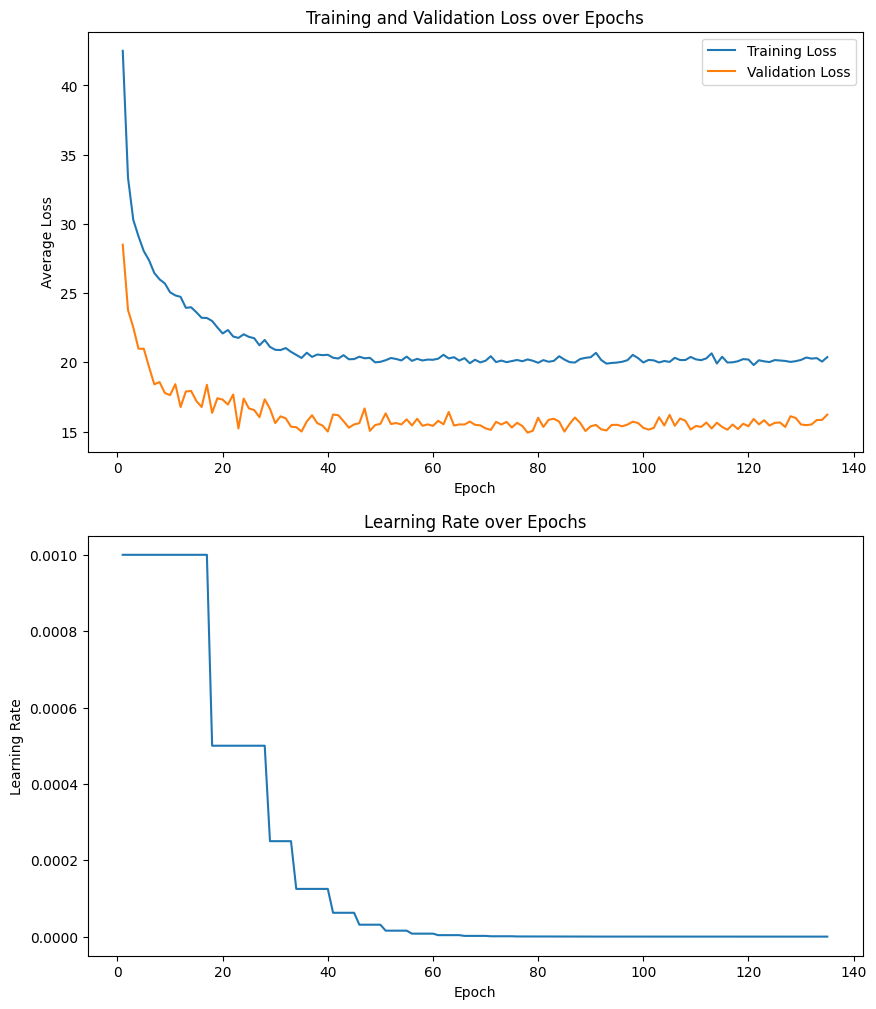

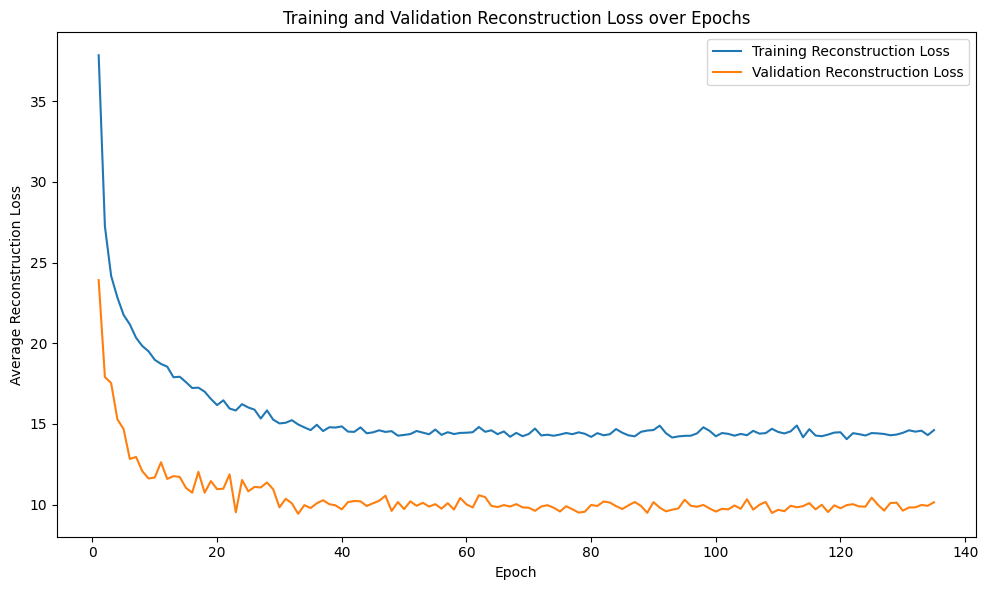

In [107]:
def train_supervised(epoch):
    model.train()
    train_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar, class_logits = model(data)
        
        # Supervised loss function
        loss, recon_loss, kl_loss, classification_loss = loss_function(
            recon_batch, data, mu, logvar, class_logits, labels
        )
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        recon_loss_total += recon_loss.item()
        kl_loss_total += kl_loss.item()
        classification_loss_total += classification_loss.item()
        
        predicted = (class_logits > 0.5).float()
        total += labels.size(0)
        correct += (predicted.squeeze() == labels).sum().item()
        
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    
    # Calculate average loss and accuracy for the epoch
    avg_loss = train_loss / len(train_loader.dataset)
    avg_recon = recon_loss_total / len(train_loader.dataset)
    avg_kl = kl_loss_total / len(train_loader.dataset)
    avg_class = classification_loss_total / len(train_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Epoch: {epoch} Average loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy

def validate_supervised():
    model.eval()
    val_loss = 0
    recon_loss_total = 0
    kl_loss_total = 0
    classification_loss_total = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            recon_batch, mu, logvar, class_logits = model(data)
            
            loss, recon_loss, kl_loss, classification_loss = loss_function(
                recon_batch, data, mu, logvar, class_logits, labels
            )
            
            val_loss += loss.item()
            recon_loss_total += recon_loss.item()
            kl_loss_total += kl_loss.item()
            classification_loss_total += classification_loss.item()
            
            predicted = (class_logits > 0.5).float()
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    
    avg_loss = val_loss / len(val_loader.dataset)
    avg_recon = recon_loss_total / len(val_loader.dataset)
    avg_kl = kl_loss_total / len(val_loader.dataset)
    avg_class = classification_loss_total / len(val_loader.dataset)
    accuracy = correct / total
    
    print(f'====> Validation loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}, '
          f'Class: {avg_class:.4f}, Accuracy: {accuracy:.4f}')
    return avg_loss, avg_recon, avg_kl, avg_class, accuracy


best_val_accuracy = 0
best_loss = float('inf')
train_losses, val_losses = [], []
train_recon_losses, val_recon_losses = [], []
train_kl_losses, val_kl_losses = [], []
train_class_losses, val_class_losses = [], []
val_accuracies = []
learning_rates = []

def early_stopping(val_losses, patience):
    if len(val_losses) > patience:
        if all(val_losses[-i-1] <= val_losses[-i] for i in range(1, patience+1)):
            return True
    return False

for epoch in range(1, num_epochs + 1):
    # Training step
    train_loss, train_recon, train_kl, train_class, train_accuracy = train_supervised(epoch)
    
    # Validation step
    val_loss, val_recon, val_kl, val_class, val_accuracy = validate_supervised()
    
    # Track losses and accuracy
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_recon_losses.append(train_recon)
    val_recon_losses.append(val_recon)
    train_kl_losses.append(train_kl)
    val_kl_losses.append(val_kl)
    train_class_losses.append(train_class)
    val_class_losses.append(val_class)
    val_accuracies.append(val_accuracy)
    learning_rates.append(optimizer.param_groups[0]['lr'])
    
    # Scheduler step
    scheduler.step(val_loss)

    # Save the best model based on validation loss
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), 'supervised_vae_best_loss.pth')
        print(f"New best model saved with validation loss: {best_loss:.4f}")
    
    # Save the best model based on validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'supervised_vae_best_acc.pth')
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    
    # Early stopping
    if early_stopping(val_losses, patience):
        print(f"Early stopping triggered at epoch {epoch}")
        break

print("Training complete.")

# Plot training and validation loss, learning rates, and reconstruction loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))

# Plot training and validation loss
ax1.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
ax1.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
ax1.set_title('Training and Validation Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Loss')
ax1.legend()

# Plot learning rate
ax2.plot(range(1, len(learning_rates) + 1), learning_rates)
ax2.set_title('Learning Rate over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Learning Rate')

# Plot the training and validation reconstruction loss
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(1, len(train_recon_losses) + 1), train_recon_losses, label='Training Reconstruction Loss')
ax.plot(range(1, len(val_recon_losses) + 1), val_recon_losses, label='Validation Reconstruction Loss')
ax.set_title('Training and Validation Reconstruction Loss over Epochs')
ax.set_xlabel('Epoch')
ax.set_ylabel('Average Reconstruction Loss')
ax.legend()

plt.tight_layout()
plt.show()


In [108]:
torch.save(model.state_dict(), 'ssfrb_vae_model.pth')

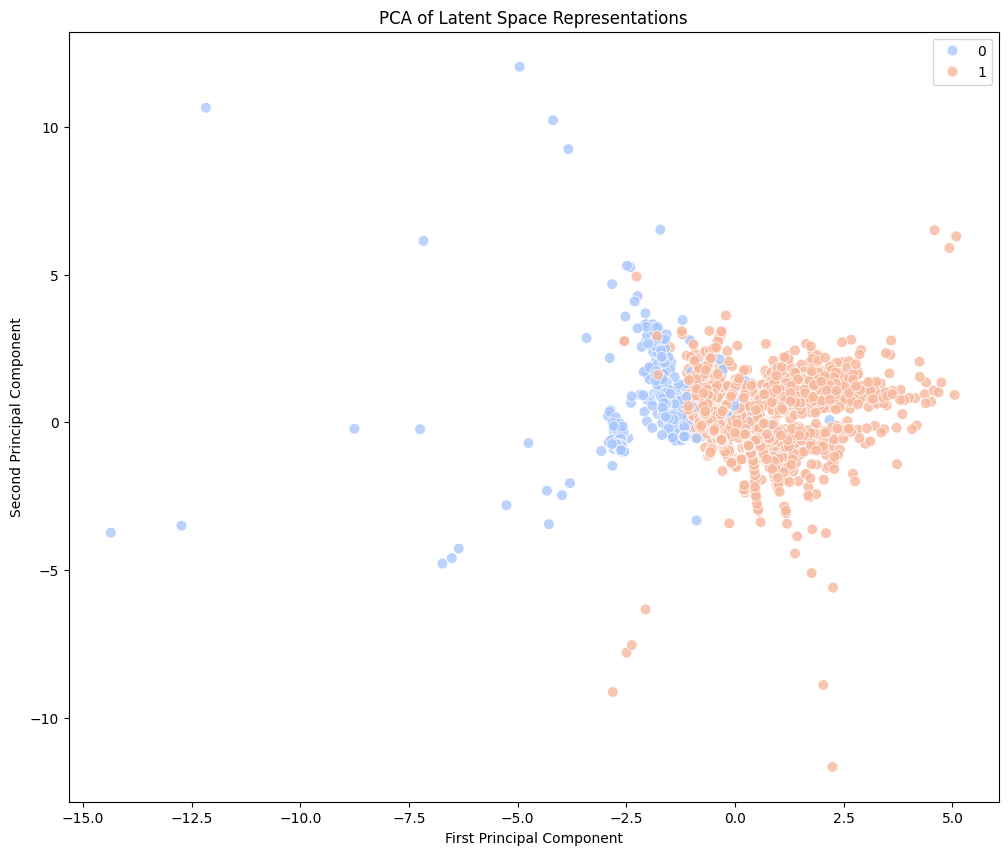

In [109]:
def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)


def visualize_latent_space_pca(latent_representations, labels, model, device):
    # Perform PCA
    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)

    # Plot the 2D latent space
    plt.figure(figsize=(12, 10))
    #scatter = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels, cmap='plasma', s=10)
    sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8)
    plt.title('PCA of Latent Space Representations')
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.show()

train_latent, train_labels_np = get_latent_representations(model, train_loader, device)
visualize_latent_space_pca(train_latent, train_labels_np, model, device)

In [143]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(train_latent)
train_clusters = kmeans.labels_

# Evaluate Clustering Performance
sil_score = silhouette_score(train_latent, train_clusters)
ari_score = adjusted_rand_score(train_labels_np, train_clusters)
conf_matrix = confusion_matrix(train_labels_np, train_clusters)

print(f"KMeans Silhouette Score: {sil_score:.4f}")
print(f"KMeans Adjusted Rand Index: {ari_score:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

KMeans Silhouette Score: 0.2405
KMeans Adjusted Rand Index: -0.0555
Confusion Matrix:
[[  75  878]
 [2142 3836]]


In [142]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(train_latent)
sil_score = silhouette_score(train_latent, gmm_clusters)
ari_score = adjusted_rand_score(train_labels_np, gmm_clusters)
print(f"GMM Silhouette Score: {sil_score:.4f}")
print(f"GMM Adjusted Rand Index: {ari_score:.4f}")

conf_matrix = confusion_matrix(train_labels_np, gmm_clusters)
class_report = classification_report(train_labels_np, gmm_clusters)
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

GMM Silhouette Score: 0.1233
GMM Adjusted Rand Index: -0.0021
Confusion Matrix:
[[ 611  342]
 [3079 2899]]
Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.64      0.26       953
           1       0.89      0.48      0.63      5978

    accuracy                           0.51      6931
   macro avg       0.53      0.56      0.45      6931
weighted avg       0.79      0.51      0.58      6931



Accuracy: 0.9813
Confusion Matrix:
[[ 170   24]
 [   2 1191]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.88      0.93       194
           1       0.98      1.00      0.99      1193

    accuracy                           0.98      1387
   macro avg       0.98      0.94      0.96      1387
weighted avg       0.98      0.98      0.98      1387



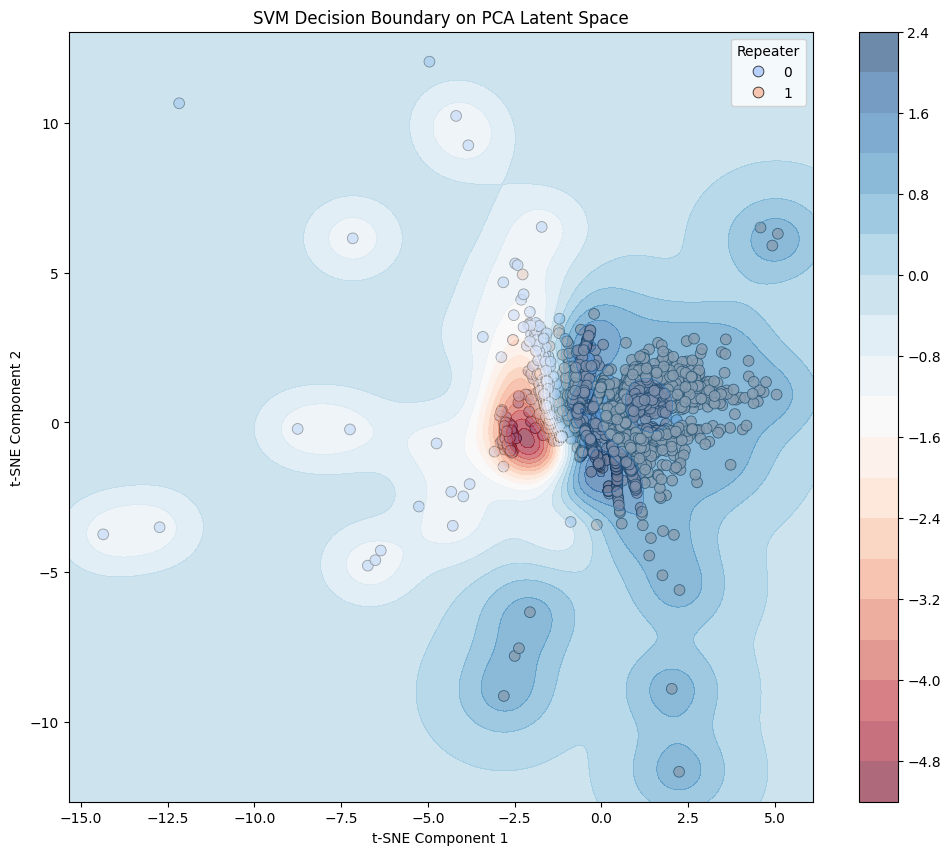

In [201]:
def svm_on_pca(latent_representations, labels, test_size=0.2, random_state=42):
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_representations)
    X_train, X_test, y_train, y_test = train_test_split(latent_pca, labels, test_size=test_size, random_state=random_state)

    svm_model = SVC(kernel='rbf', random_state=random_state)
    svm_model.fit(X_train, y_train)

    # Predict on test set
    y_pred = svm_model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 10))

    sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8, edgecolor='k')

    # Plot decision boundary
    x_min, x_max = latent_pca[:, 0].min() - 1, latent_pca[:, 0].max() + 1
    y_min, y_max = latent_pca[:, 1].min() - 1, latent_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    Z = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap="RdBu", alpha=0.6)  # SVM decision boundary
    
    # Titles and labels
    plt.colorbar()
    plt.title('SVM Decision Boundary on PCA Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.legend(title='Repeater')

    plt.show()

svm_on_pca(train_latent, train_labels_np, test_size=0.2, random_state=42)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Accuracy: 0.9784
Confusion Matrix:
[[ 164   24]
 [   6 1193]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       188
           1       0.98      0.99      0.99      1199

    accuracy                           0.98      1387
   macro avg       0.97      0.93      0.95      1387
weighted avg       0.98      0.98      0.98      1387



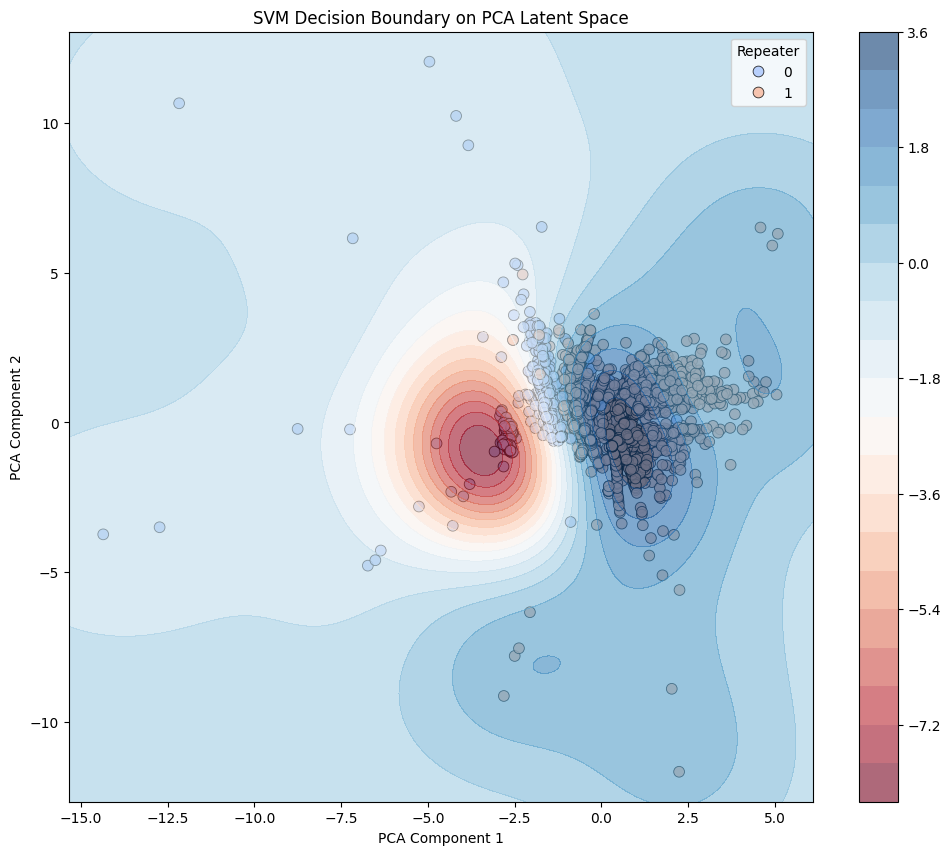

In [113]:
def svm_on_pca_grid(latent_representations, labels, test_size=0.2, random_state=42):
    pca = PCA(n_components=2)
    latent_pca = pca.fit_transform(latent_representations)
    
    X_train, X_test, y_train, y_test = train_test_split(latent_pca, labels, test_size=test_size, random_state=random_state)
    
    param_grid = {
        'C': [0.1, 1, 10, 100], 
        'gamma': ['scale', 'auto', 0.01, 0.1, 1],
        'kernel': ['rbf', 'linear'] 
    }

    grid_search = GridSearchCV(SVC(random_state=random_state), param_grid, cv=5, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best parameters found: {best_params}")

    best_svm_model = grid_search.best_estimator_
    y_pred = best_svm_model.predict(X_test)

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=latent_pca[:, 0], y=latent_pca[:, 1], hue=labels, palette='coolwarm', s=60, alpha=0.8, edgecolor='k')

    x_min, x_max = latent_pca[:, 0].min() - 1, latent_pca[:, 0].max() + 1
    y_min, y_max = latent_pca[:, 1].min() - 1, latent_pca[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    Z = best_svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, levels=20, cmap="RdBu", alpha=0.6)
    
    plt.colorbar()
    plt.title('SVM Decision Boundary on PCA Latent Space')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend(title='Repeater')

    plt.show()

svm_on_pca_grid(train_latent, train_labels_np, test_size=0.2, random_state=42)

## Evaluating Classifier Head

Validation Accuracy: 0.9706
Classification Report:
               precision    recall  f1-score   support

Non-Repeater       0.89      0.89      0.89       238
    Repeater       0.98      0.98      0.98      1495

    accuracy                           0.97      1733
   macro avg       0.94      0.94      0.94      1733
weighted avg       0.97      0.97      0.97      1733

Confusion Matrix:
 [[ 213   25]
 [  26 1469]]


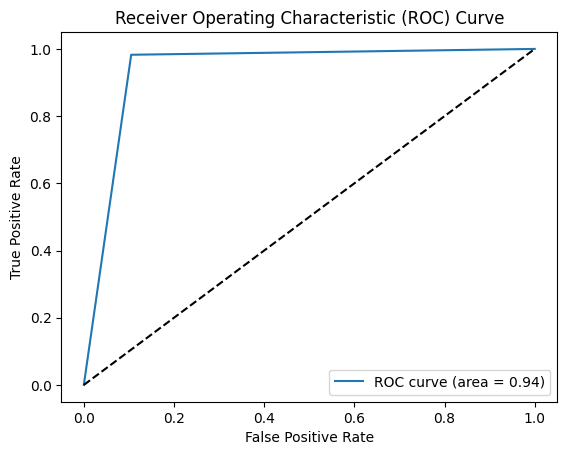

In [114]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels


val_accuracy, val_class_report, val_conf_matrix, val_preds, val_labels = evaluate_classifier(model, val_loader, device)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print("Classification Report:\n", val_class_report)
print("Confusion Matrix:\n", val_conf_matrix)

fpr, tpr, thresholds = roc_curve(val_labels, val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [194]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [125]:
original_data = pd.read_csv('frb-data.csv')
original_data['Repeater'] = original_data['Repeater'].map({'Yes': 1, 'No': 0}).fillna(0).astype(int)

misclassified_non_repeaters = (val_labels == 0) & (val_preds == 1)
misclassified_indices = val_indices[misclassified_non_repeaters]
misclassified_sources = original_data.loc[misclassified_indices, "Source"]

misclassified_sources

3092    FRB20181226E
3237    FRB20180919B
3247    FRB20190201B
3410    FRB20190806B
3321    FRB20190630D
3310    FRB20190316A
2950    FRB20190224C
8054    FRB20220912A
6603    FRB20220825A
8130    FRB20220912A
5321    FRB19970528A
6607    FRB20220926A
6614    FRB20221106A
7737    FRB20240123A
3117    FRB20181129B
7724    FRB20230124A
6591    FRB20220208A
7950    FRB20220912A
3411    FRB20191223B
2961    FRB20180814B
3129    FRB20190402A
3042    FRB20190128C
5358    FRB20001118A
3419    FRB20201123A
3228    FRB20190410A
Name: Source, dtype: object

In [196]:
for source in misclassified_sources:
    if source in luo_list:
        print(source)

FRB20190128C
FRB20190410A


In [195]:
for source in misclassified_sources:
    if source in garcia_list:
        print(f"{source}")

FRB20181226E
FRB20190128C
FRB20190410A


In [189]:
for source in misclassified_sources:
    if source in zhu_ge_list:
        print(source)

FRB20181226E
FRB20190410A


In [141]:
for source in misclassified_sources:
    if source in garcia_list and source in luo_list and source in zhu_ge_list:
        print(source)

FRB20190410A


In [140]:
for source in misclassified_sources:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

FRB20181226E
FRB20190128C
FRB20190410A


## SVM on PCA latent space analysis

[[ 210   28]
 [   3 1492]]


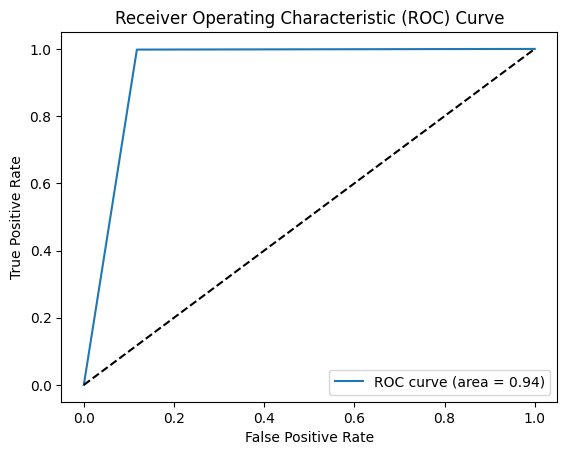

[ True  True  True ...  True  True  True]


In [204]:
val_latent, val_labels_np = get_latent_representations(model, val_loader, device)
pca = PCA(n_components=2, random_state=42)
pca.fit(train_latent)

train_latent_pca = pca.transform(train_latent)
val_latent_pca = pca.transform(val_latent)

svm_pca = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_pca.fit(train_latent_pca, train_labels_np)

val_pca_preds = svm_pca.predict(val_latent_pca)
print(confusion_matrix(val_labels_np, val_pca_preds))

fpr, tpr, thresholds = roc_curve(val_labels_np, val_pca_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [197]:
misclassified_repeaters_svm = (val_labels_np == 0) & (val_pca_preds == 1)   

misclassified_repeaters_indices_svm = val_indices[misclassified_repeaters_svm]
misclassified_repeaters_sources_svm = original_data.loc[misclassified_repeaters_indices_svm, "Source"]

misclassified_repeaters_sources_svm

6577    FRB20210202D
3092    FRB20181226E
2875    FRB20181222E
3339    FRB20190628B
3247    FRB20190201B
3028    FRB20180714A
3321    FRB20190630D
2950    FRB20190224C
3349    FRB20190617A
3134    FRB20190502B
6603    FRB20220825A
2836    FRB20171209A
3404    FRB20190627C
6588    FRB20220121B
6607    FRB20220926A
3145    FRB20181112A
3229    FRB20190419B
7737    FRB20240123A
3158    FRB20190213D
3388    FRB20190613B
6591    FRB20220208A
3371    FRB20190609B
6604    FRB20220831A
3093    FRB20181228B
2849    FRB20181231B
3070    FRB20190304B
2856    FRB20190224D
3188    FRB20181214C
Name: Source, dtype: object

In [192]:
for source in misclassified_repeaters_sources_svm:
    if source in garcia_list:
        print(f"{source}")
        
for source in misclassified_repeaters_sources_svm:
    if source in luo_list:
        print(f"{source}")

for source in misclassified_repeaters_sources_svm:
    if source in zhu_ge_list:
        print(f"{source}")

FRB20181226E
FRB20181231B
FRB20181226E
FRB20190617A
FRB20181231B


In [193]:
for source in misclassified_repeaters_sources_svm:
    if source in garcia_list or source in luo_list or source in zhu_ge_list:
        print(source)

FRB20181226E
FRB20190617A
FRB20181231B


In [199]:
for source in misclassified_repeaters_svm:
    if source in misclassified_sources:
        print(source)
        
# indicates no overlap